# <center>Trabajo Práctico N°1 : Reservas de Hotel</center>

**Grupo:** N°28 - The Kingdom

**Checkpoint N°**: 2

**Alumnos**:


*   Jurgens, Cecilia Ines
*   Schipani, Martin Sebastian
*   Soto, Marylin Nicole

**Corrector:** Franco Mastelli

---


In [1]:
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import make_scorer, f1_score

from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
ds_hotel_test = pd.read_csv("hotels_test.csv")
df_hotel_test = ds_hotel_test.copy()
ds_hotel_train = pd.read_csv("hotels_train.csv")
df_hotel_train = ds_hotel_train.copy()

## Preprocesamiento de Datasets

Analizamos la cantidad de filas y columnas entre el dataset de train y de test:

In [4]:
print("El dataset train tiene "f"{df_hotel_train.shape[0]}"" filas y "f"{df_hotel_train.shape[1]}"" columnas.")
print("El dataset test tiene "f"{df_hotel_test.shape[0]}"" filas y "f"{df_hotel_test.shape[1]}"" columnas.")

El dataset train tiene 61913 filas y 31 columnas.
El dataset test tiene 26535 filas y 31 columnas.


Determinamos que columnas faltan en cada dataset:

In [5]:
columnas_faltantes_train = set(df_hotel_test.columns)-set(df_hotel_train.columns)
columnas_faltantes_test = set(df_hotel_train.columns) - set(df_hotel_test.columns)

print('Columnas faltantes en el dataset de Train: ', columnas_faltantes_train)
print('Columnas faltantes en el dataset de Test: ', columnas_faltantes_test)


Columnas faltantes en el dataset de Train:  {'reservation_status_date'}
Columnas faltantes en el dataset de Test:  {'is_canceled'}


### Dataset Train:

Aplicamos la limpieza que fue detallada en el checkpoint 1 en el dataset de train:

In [6]:
#COUNTRY
##Reemplazamos los valores nulos con la moda
df_hotel_train.fillna({'country':-1}, inplace = True)
df_hotel_train.replace({-1, "PRT"})

country_top_train = df_hotel_train['country'].value_counts()
top_5_country_train = country_top_train.head(5).index.tolist()
df_hotel_train['country'] = df_hotel_train['country'].apply(lambda x: x if x in top_5_country_train else 'other')

#LEAD_TIME
##Tratamiento de outliers:
df_hotel_train.drop(df_hotel_train[df_hotel_train['lead_time']>=500].index, axis='index', inplace=True)

#STAYS_IN_WEEK_NIGHTS
##Tratamiento de outliers:
df_hotel_train.drop(df_hotel_train[df_hotel_train['stays_in_week_nights']>=25].index, axis='index', inplace=True)

#ADULTS
##Tratamiento de Outliers:
df_hotel_train.drop(df_hotel_train[df_hotel_train['adults']==0].index, axis='index', inplace=True)
df_hotel_train.drop(df_hotel_train[df_hotel_train['adults']>3].index, axis='index', inplace=True)

#CHILDREN
##Eliminacion de los registros con datos nulos de esta variable:
df_hotel_train.drop(df_hotel_train[df_hotel_train['children'].isna() == True].index, axis='index', inplace=True)

##Tratiento de outliers
df_hotel_train.drop(df_hotel_train[df_hotel_train['children']>=10].index, axis='index', inplace=True)

#BABIES
##Tratamiento de Outliers:
df_hotel_train.drop(df_hotel_train[df_hotel_train['babies']>=9].index, axis='index', inplace=True)

#PREVIOUS_CANCELLATIONS
##Tratamiento de Outliers
df_hotel_train.drop(df_hotel_train[df_hotel_train['previous_cancellations']>=2].index, axis='index', inplace=True)

#DAYS_IN_WAITING_LIST
##Tratamiento de outliers
df_hotel_train.drop(df_hotel_train[df_hotel_train['days_in_waiting_list']>=200].index, axis='index', inplace=True)

#ADR
##Tratamiento de Outliers:
df_hotel_train.drop(df_hotel_train[df_hotel_train['adr']<=0].index, axis='index', inplace=True)
df_hotel_train.drop(df_hotel_train[df_hotel_train['adr']>=400].index, axis='index', inplace=True)

#REQUIRED_CAR_PARKING_SPACES
##Tratamiento de outliers:
df_hotel_train.loc[(df_hotel_train['adults'] == 2) & (df_hotel_train['required_car_parking_spaces'] == 3), 'required_car_parking_spaces'] = 2
df_hotel_train.loc[(df_hotel_train['adults'] == 2) & (df_hotel_train['required_car_parking_spaces'] == 8), 'required_car_parking_spaces'] = 2

#TOTAL_OF_SPECIAL_REQUESTS
df_hotel_train.loc[(df_hotel_train['total_of_special_requests'] >= 4), 'total_of_special_requests'] = 1

#AGENT
df_hotel_train.dropna(subset=['agent'], inplace = True)

Convertimos los meses del año en numeros:

In [7]:
meses_a_numeros ={
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July':7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
df_hotel_train.arrival_date_month = df_hotel_train.arrival_date_month.map(meses_a_numeros)

Transformamos los datos de children en int:

In [8]:
df_hotel_train['children'] = df_hotel_train['children'].astype(int)

Reemplazamos en meal todos aquellos que dicen undefined por SC (como es aclarado en el paper):

In [9]:
df_hotel_train.loc[df_hotel_train.loc[:,'meal'] == 'Undefined','meal'] ='SC'

Convertimos las letras de habitaciones de los hoteles por numeros:

In [10]:
dormitorio_letra_a_numero ={
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'H': 8,
    'I': 9,
    'K': 10,
    'L': 11
}
df_hotel_train.reserved_room_type = df_hotel_train.reserved_room_type.map(dormitorio_letra_a_numero)

Elimino todas aquellas columnas que no se necesitaran en la busqueda de arboles:

In [11]:
columnas_eliminar =[ 'id', 'assigned_room_type', 'company']
df_hotel_train.drop(columnas_eliminar, axis='columns', inplace=True)

One hot encoding para variables categoricas:

In [12]:
columnas_dummies = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type']
df_hotel_train = pd.get_dummies(df_hotel_train, columns= columnas_dummies, drop_first= True)

Verificamos que no nos queden valores nulos en el dataset train:

In [14]:
df_hotel_train.isna().sum()

lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
agent                             0
days_in_waiting_list              0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
is_canceled                       0
hotel_Resort Hotel                0
meal_FB                           0
meal_HB                           0
meal_SC                           0
country_ESP                       0
country_FRA                       0
country_GBR                 

### Dataset Test:

In [15]:
df_hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  object 
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  float64
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

Analizamos los valores nulos del dataset:

In [16]:
df_hotel_test.isna().sum()

hotel                                 0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
babies                                0
meal                                  0
country                              95
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              3363
company                           25218
days_in_waiting_list                  0


In [17]:
#COUNTRY
##Reemplazamos los valores nulos con la moda
df_hotel_test.fillna({'country':-1}, inplace = True)
df_hotel_test.replace({-1, "PRT"})

#country_top_test = df_hotel_test['country'].value_counts()
#top_5_country_test = country_top_test.head(5).index.tolist()
df_hotel_test['country'] = df_hotel_test['country'].apply(lambda x: x if x in top_5_country_train else 'other')

#AGENT
#df_hotel_test.dropna(subset=['agent'], inplace = True)
df_hotel_test.fillna({'agent':-1}, inplace = True)


In [18]:
columnas_eliminar_test = ['id', 'assigned_room_type', 'company', 'reservation_status_date' ]
df_hotel_test.drop(columnas_eliminar_test, axis='columns', inplace= True)

Convertimos los meses del año en numeros:

In [19]:
meses_a_numeros_test ={
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July':7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
df_hotel_test.arrival_date_month = df_hotel_test.arrival_date_month.map(meses_a_numeros_test)

Transformamos los datos de children en int:

In [20]:
df_hotel_test['children'] = df_hotel_test['children'].astype(int)

Reemplazamos en meal todos aquellos que dicen undefined por SC (como es aclarado en el paper):

In [21]:
df_hotel_test.loc[df_hotel_test.loc[:,'meal'] == 'Undefined','meal'] ='SC'

Convertimos las letras de habitaciones de los hoteles por numeros:

In [22]:
dormitorio_letra_a_numero_test ={
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'H': 8,
    'I': 9,
    'K': 10,
    'L': 11,
    'P': 12
}
df_hotel_test.reserved_room_type = df_hotel_test.reserved_room_type.map(dormitorio_letra_a_numero_test)

One hot Encoding para variables categoricas:

In [23]:
columnas_dummies_test = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type']
df_hotel_test = pd.get_dummies(df_hotel_test, columns = columnas_dummies_test, drop_first= True)

Verificamos que no nos queden valores nulos en el dataset test:

In [24]:
df_hotel_test.isna().sum()

lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
agent                             0
days_in_waiting_list              0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
hotel_Resort Hotel                0
meal_FB                           0
meal_HB                           0
meal_SC                           0
country_ESP                       0
country_FRA                       0
country_GBR                       0
country_PRT                 

## Entrenamiento y Prediccion

### Sin Optimizacion de Hiperparametros

In [25]:
target = 'is_canceled'
df_hotel_train_x = df_hotel_train.drop(target, axis = 'columns', inplace = False)

features = df_hotel_train_x.columns.tolist()

df_hotel_train_y = df_hotel_train['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(df_hotel_train_x,
                                                    df_hotel_train_y,
                                                    test_size = 0.15,
                                                    random_state = 28,
                                                    stratify = df_hotel_train_y.values
                                                    )

Ahora ya tenemos nuestros datos de tarin y test. Iniciamos nuestro modelo con una profundidad de 20 y el criterio de gini:

In [26]:
tree_model = tree.DecisionTreeClassifier(criterion="gini",
                                         max_depth = 20,
                                         )

model = tree_model.fit(X = x_train, y = y_train)
y_pred = model.predict(x_test)

#### Matriz de Confusion:

Graficamos la matriz de confusion para visualizar nuestros resultados:

Text(50.722222222222214, 0.5, 'True')

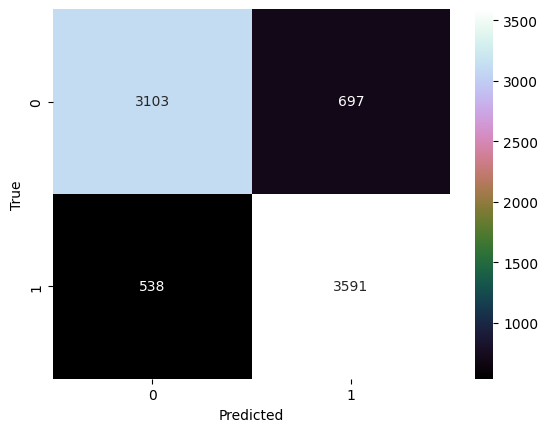

In [27]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap="cubehelix", annot = True, fmt = 'g')
plt.xlabel('Predicted')
plt.ylabel('True')

#### Metricas:

Veamos las metricas del arbol sin optimizar con los hiperparametros:

In [28]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: " + str(accuracy))
print("Recall: " + str(recall))
print("f1 Score: " + str(f1))
print("Precision: " + str(precision))

Accuracy: 0.8442426535502585
Recall: 0.8697021070477113
f1 Score: 0.8532731376975169
Precision: 0.8374533582089553


#### Arbol de Decision

Grafico del arbol sin optimizar:

Se utilizo un max_depth de 3 para su mejor visualizacion.

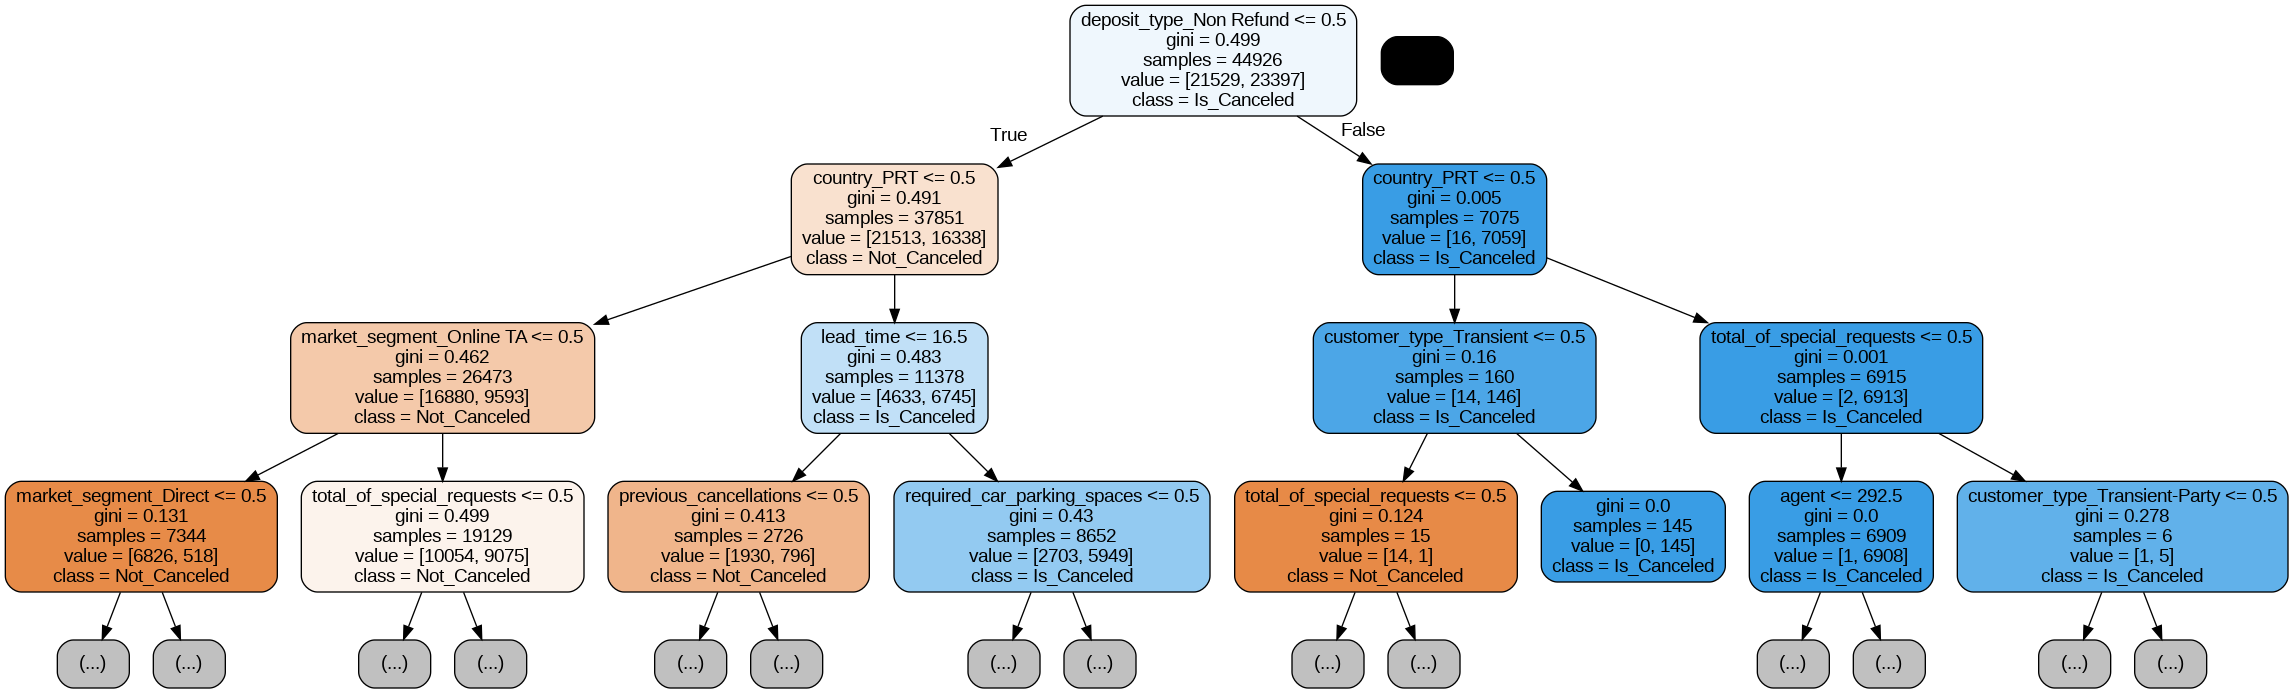

In [29]:
dot_data = StringIO()
export_graphviz(tree_model,
                out_file = dot_data,
                filled = True,
                rounded = True,
                feature_names = df_hotel_train_x.columns.tolist(),
                max_depth = 3,
                class_names = ['Not_Canceled', 'Is_Canceled'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

+ Reglas de Decision:

In [30]:
print(export_text(tree_model, feature_names=list(df_hotel_train_x.columns.tolist())))

|--- deposit_type_Non Refund <= 0.50
|   |--- country_PRT <= 0.50
|   |   |--- market_segment_Online TA <= 0.50
|   |   |   |--- market_segment_Direct <= 0.50
|   |   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |   |--- stays_in_week_nights <= 1.50
|   |   |   |   |   |   |--- arrival_date_year <= 2015.50
|   |   |   |   |   |   |   |--- arrival_date_week_number <= 34.50
|   |   |   |   |   |   |   |   |--- lead_time <= 85.00
|   |   |   |   |   |   |   |   |   |--- lead_time <= 2.50
|   |   |   |   |   |   |   |   |   |   |--- adr <= 109.25
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- adr >  109.25
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- lead_time >  2.50
|   |   |   |   |   |   |   |   |   |   |--- adr <= 127.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- adr >  127.50
|   |   |   |   |   |   | 

####Exportacion del modelo

In [31]:
y_pred_sin_optimizar = model.predict(df_hotel_test)
df_summision = pd.DataFrame({'id': ds_hotel_test['id'], 'is_canceled': y_pred_sin_optimizar})
df_summision.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [32]:
df_summision.to_csv('summit_sin_hiper.csv', index = False)

### Con Optimizacion de Hiperparametros:

#### Random Search Cross Validation:

In [43]:
combinaciones = 10
folds = 10
params_grid = {'criterion':['gini','entropy'],
               'splitter': ['best','random'],
               'min_samples_leaf':list(range(2,20)),
               'min_samples_split':list(range(2,20)),
               'max_depth':list(range(10,30)),
               'class_weight': ['balanced'],
               #'ccp_alpha':np.linspace(0,0.05,combinaciones)
               }

kfoldcv = StratifiedKFold(n_splits=folds)
base_tree = DecisionTreeClassifier()
scorer_fn = make_scorer(f1_score)

randomcv = RandomizedSearchCV(estimator = base_tree,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_iter = combinaciones,
                              random_state = 28)

randomcv.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(),
                   param_distributions={'class_weight': ['balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, 11, 12,
                                                             13, 14, 15, 16, 17,
                                                             18, 19],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19],
                                        'splitter': ['best', 'random']},
                   random_state=28, scoring=make_scorer(f1_score))

Los mejores parametros del arbol:

In [44]:
print(randomcv.best_params_)
print()
print("F1 score: ", randomcv.best_score_)

{'splitter': 'best', 'min_samples_split': 16, 'min_samples_leaf': 16, 'max_depth': 21, 'criterion': 'entropy', 'class_weight': 'balanced'}

F1 score:  0.8450718523424714


In [45]:
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_
for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

hotel_Resort Hotel: 0.0004428377599851983
distribution_channel_Direct: 0.0006005219581327999
country_FRA: 0.0006989372081082973
children: 0.0007099248016620702
market_segment_Groups: 0.0007189442660811223
country_GBR: 0.0008902953959248971
distribution_channel_TA/TO: 0.0009671321571687463
previous_bookings_not_canceled: 0.0009859936488313616
country_ESP: 0.0012224632451907312
adults: 0.001425646601101996
is_repeated_guest: 0.001615677841641991
market_segment_Offline TA/TO: 0.0018163630546648077
meal_SC: 0.002434039208593983
reserved_room_type: 0.0025165591092787907
country_other: 0.002550681768341089
meal_HB: 0.002781467063403216
days_in_waiting_list: 0.0037688323546262096
customer_type_Transient-Party: 0.004625113390207347
arrival_date_month: 0.006419421568642748
stays_in_weekend_nights: 0.009703373423281104
booking_changes: 0.012112238880221966
stays_in_week_nights: 0.012400504936941701
market_segment_Direct: 0.01799530477521817
customer_type_Transient: 0.02149653550241384
arrival_da

##### Prediccion del Modelo con los hiperparametros:

In [46]:
arbol = DecisionTreeClassifier().set_params(**randomcv.best_params_)

arbol.fit(x_train, y_train)

reglas = export_text(arbol, feature_names = list(features))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- required_car_parking_spaces <= 0.50
|   |   |--- country_PRT <= 0.50
|   |   |   |--- market_segment_Online TA <= 0.50
|   |   |   |   |--- market_segment_Direct <= 0.50
|   |   |   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |   |   |--- stays_in_week_nights <= 1.50
|   |   |   |   |   |   |   |--- arrival_date_year <= 2015.50
|   |   |   |   |   |   |   |   |--- arrival_date_week_number <= 34.50
|   |   |   |   |   |   |   |   |   |--- lead_time <= 85.00
|   |   |   |   |   |   |   |   |   |   |--- lead_time <= 13.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- lead_time >  13.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- lead_time >  85.00
|   |   |   |   |   |   |   |   |   |   |--- lead_time <= 113.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- lead_

##### Matriz de Confusion:

Text(50.722222222222214, 0.5, 'True')

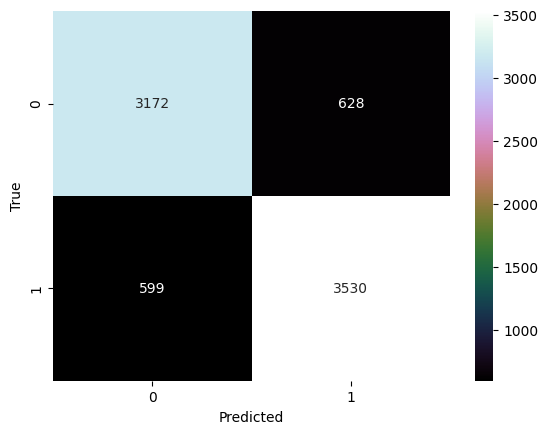

In [47]:
y_pred = arbol.predict(x_test)

matriz = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz, cmap='cubehelix', annot = True, fmt = 'g')
plt.xlabel('Predicted')
plt.ylabel('True')

##### Metricas

In [48]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average = 'binary')))

F1-Score: 0.8519367684324846


#### Entrenamiento CrossValidation

In [52]:
kfoldcv = StratifiedKFold(n_splits = folds)

arbol = DecisionTreeClassifier().set_params(**randomcv.best_params_)

scorer_fn = make_scorer(f1_score)

resultados = cross_validate(arbol, x_train, y_train, cv = kfoldcv, scoring = scorer_fn, return_estimator = True)

metricsCV = resultados['test_score']
mejor_performance = resultados['estimator'][np.where(metricsCV == max(metricsCV))[0][0]]

##### Grafico de Boxplot

Text(0.5, 1.0, 'Modelo 10 folds')

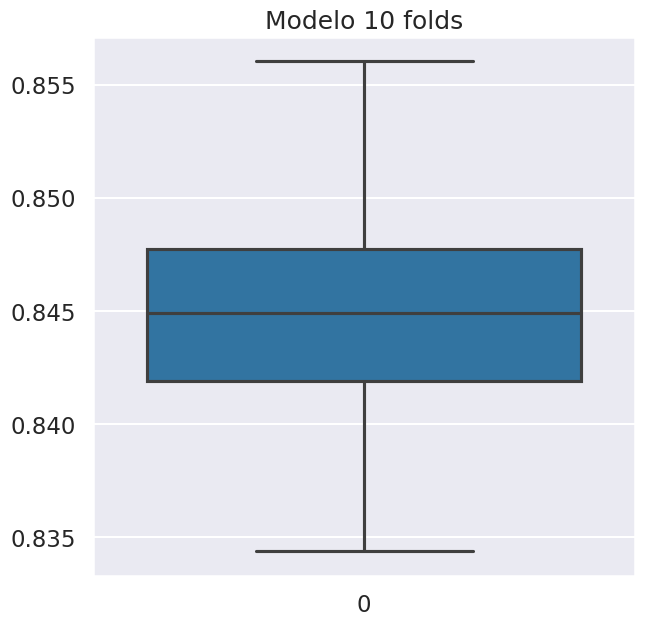

In [53]:
metric_labelsCV = ['F1 Score']*len(metricsCV)
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(7,7))
sns.boxplot(metricsCV)
plt.title("Modelo 10 folds")

##### Metricas:

In [54]:
y_pred=mejor_performance.predict(x_test)
print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average = 'binary')))


              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3800
           1       0.85      0.86      0.85      4129

    accuracy                           0.85      7929
   macro avg       0.85      0.85      0.85      7929
weighted avg       0.85      0.85      0.85      7929

F1-Score: 0.8534524384355383


##### Matriz de Confusion

Text(34.08333333333333, 0.5, 'True')

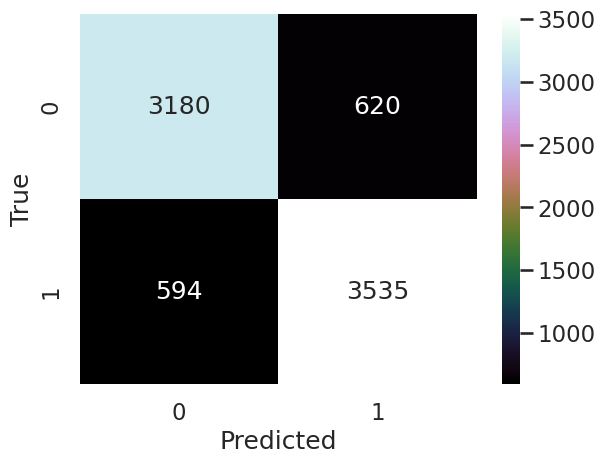

In [56]:
matriz = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz, cmap='cubehelix', annot = True, fmt = 'g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [57]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: " + str(accuracy))
print("Recall: " + str(recall))
print("f1 Score: " + str(f1))
print("Precision: " + str(precision))

Accuracy: 0.8468911590364485
Recall: 0.8561395010898523
f1 Score: 0.8534524384355383
Precision: 0.8507821901323707


##### Exportacion de la prediccion

In [58]:
y_pred_s =  mejor_performance.predict(df_hotel_test)
df_summision = pd.DataFrame({'id': ds_hotel_test['id'], 'is_canceled': y_pred_s})
df_summision.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,0
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [59]:
df_summision.to_csv('summit.csv', index = False)

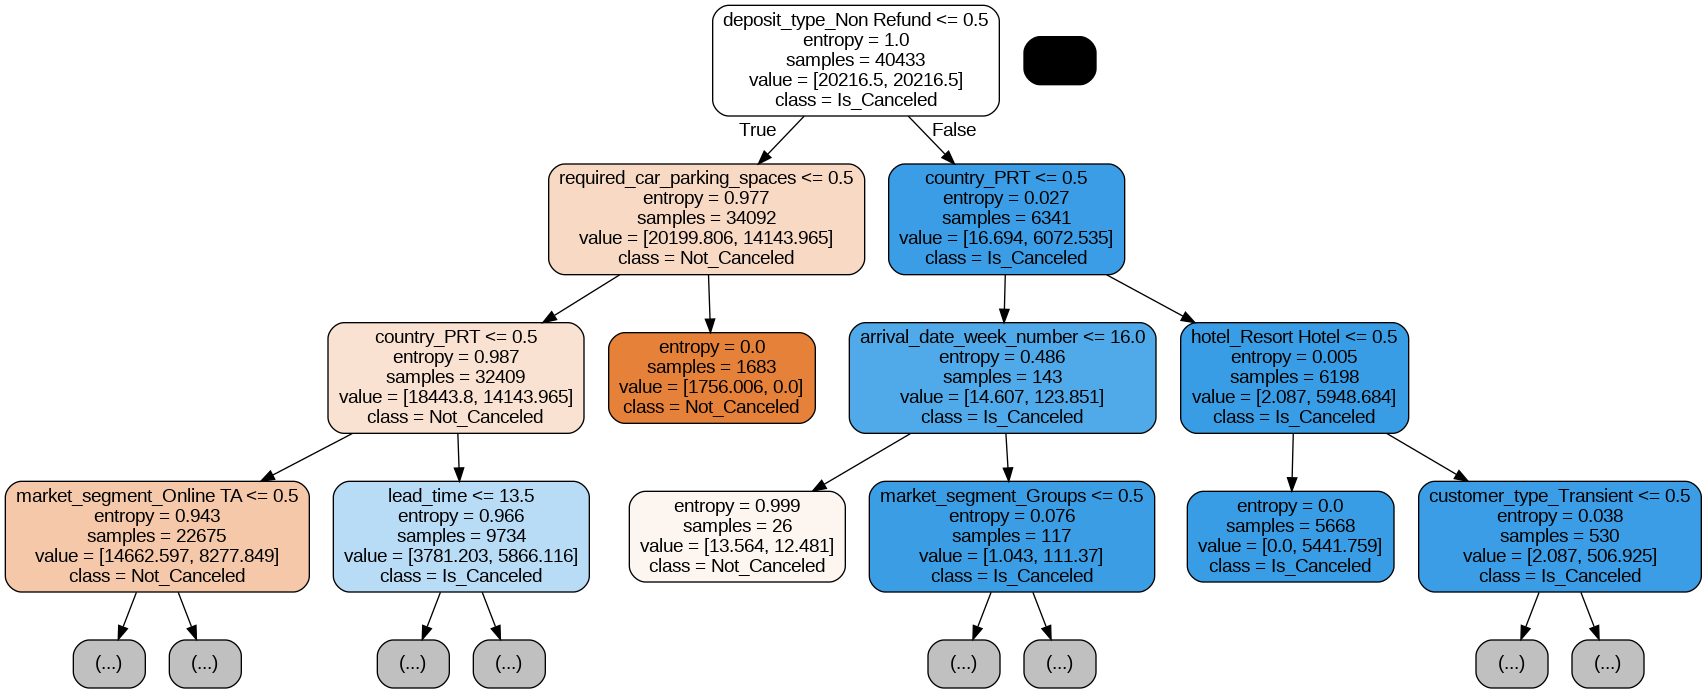

In [60]:
dot_data = StringIO()
export_graphviz(mejor_performance,
                out_file = dot_data,
                filled = True,
                rounded = True,
                feature_names = df_hotel_train_x.columns.tolist(),
                max_depth = 3,
                class_names = ['Not_Canceled', 'Is_Canceled'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Conclusiones:

### Metricas:

+ <u>Precision:</u> Esta metrica se trata de los true positives sobre todos los casos positivos. En nuestro caso, tenemos un 0,8508 de metrica y quiere decir que una reserva es cancelada con un 85,08%

+ <u>Recall:</u> Permite identificar la capacidad de nuestro modelo de encontrar correctamente los true positive. En nuestro caso, dice que el 85,61% de las reservas son efectivamente canceladas.

+ <u>F1-Score:</u> Esta métrica combina la precision y el recall, para obtener un valor mucho más objetivo. Es una medida ponderada entre el recall y la precision. En nuestro caso, toma el valor de 0,853

+ <u>Accuracy:</u>  Permite determinar el ratio de predicciones correctas, tanto como true positive y true negative. Esto quiere decir que en nuestro modelo, hay un 84,69% de predecir correctamente si la reserva es cancelada o no.

Nuestra métrica a considerar es f1-score ya que representa un ponderado de recall y precision.

### Arbol:

Un arbol de decision es un modelo de prediccion. El arbol comienza por deposit_type_NonRefund <= 0.5 como su nodo principal, debido a su alta correlacion con el target. Dependiendo si es True o False, se dirige a la izquierda o derecha y se evalua con Country_PRT <= 0.5 o required_car_parking_spaces <=0.5  y hasta llegar al último nodo que será is_canceled o not_canceled. Mientras el nodo sea un naranja más fuerte, mayor es la confianza en su resultado.

En el grafico mostrado, solo se mostro hasta una profundidad de 3 por cuestiones de claridad y visualizacion.
